In [92]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import tqdm

In [93]:
with open('/home/acdealy/notebooks/ice-shelf-roughness/pig_data.pkl', 'rb') as handle:
    pig_data = pickle.load(handle)

In [94]:
pig_data

,E,N,R,A_inv
0,"[-1651481.758750924, -1651383.3505507752, -165...","[-353762.3925396986, -353756.3016055465, -3537...","[0.044566521525594704, 0.05461466200083205, 0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,"[-1652193.2093462404, -1652092.7983206566, -16...","[-350460.6790672391, -350454.4832210079, -3504...","[0.05899875268627665, 0.04935713275830416, 0.0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,"[-1672591.9401274992, -1672493.3408485726, -16...","[-236488.7958128777, -236489.89538038473, -236...","[4.42563651853829, 5.031383551301873, 5.692252...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,"[-1673069.3582808287, -1672970.7653911032, -16...","[-233145.59793909022, -233146.68285816617, -23...","[2.8661641492825054, 2.777150017669737, 2.6595...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,"[-1673546.4988870525, -1673447.9133086596, -16...","[-229805.40480977326, -229806.5608603112, -229...","[1.4612791998407701, 1.4798293031017902, 1.461...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...
842,"[-1546411.4302152717, nan, nan, nan, nan, nan,...","[-295348.63134261983, nan, nan, nan, nan, nan,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[5.587188731901959, nan, nan, nan, nan, nan, n..."
843,"[-1541693.785706294, nan, -1542711.9281577487,...","[-297193.65877807105, nan, -297559.00651088875...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[5.4752397630419045, nan, 5.496831383882527, 5..."
844,"[-1666993.1931706963, -1666894.5976901152, -16...","[-272660.3197151092, -272659.1269328333, -2726...","[2.01134671360437, 2.0043385579857897, 2.00471...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
845,"[-1667619.3083545887, -1667465.261884184, -166...","[-269326.4261382771, -269324.668346543, -26932...","[13.99723584195711, 9.497140462824827, 8.27676...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


100%|██████████| 847/847 [00:51<00:00, 16.37it/s]


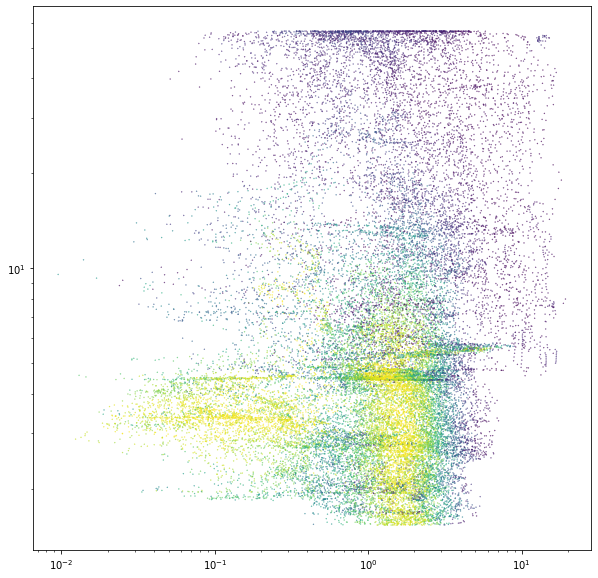

In [95]:
#bounding roughness and inverse data to the pig shapefile

fig, ax = plt.subplots(figsize=(10,10))

study_shelf_id = 590802
all_shelf_outline_path = '/home/acdealy/notebooks/ice-shelf-roughness/shapefiles/USNIC_ANTARC_shelf_2022_epsg3031.shp'
all_shelf_outline = gpd.read_file(all_shelf_outline_path)
shape = all_shelf_outline[all_shelf_outline['OBJECTID']==study_shelf_id] 

roughness = []
inverse = []
easting = []
northing = []

#plotting with point density 
for j in tqdm.trange(np.shape(pig_data)[0]):
    x = np.array(pig_data['E'].iloc[j])
    y = np.array(pig_data['N'].iloc[j])
    r = np.array(pig_data['R'].iloc[j])
    a = np.array(pig_data['A_inv'].iloc[j])
    on_shelf = []
    for k in range(len(pig_data['E'].iloc[j])):
        pts_on_shelf = shape.contains(Point(x[k],y[k]))
        on_shelf.append(pts_on_shelf.values[0])
    on_shelf = np.array(on_shelf)
    x = x[on_shelf==True]
    y = y[on_shelf==True]
    r = r[on_shelf==True]
    a = a[on_shelf == True]
    roughness.append(r)
    inverse.append(a)
    easting.append(x)
    northing.append(y)
#need to get rid of any nans or deal with that somehow idk (for gaussian_kde) !!!!!!LOSING DATA HERE!!!!!!
    if len(r)>0 and len (a)>0 and not(np.isnan(r).any()) and not(np.isnan(a).any()):
        xy = np.vstack([r,a])
        z = gaussian_kde(xy)(xy)
        points = ax.scatter(r, a, c=z, s=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

100%|██████████| 847/847 [01:24<00:00, 10.06it/s]


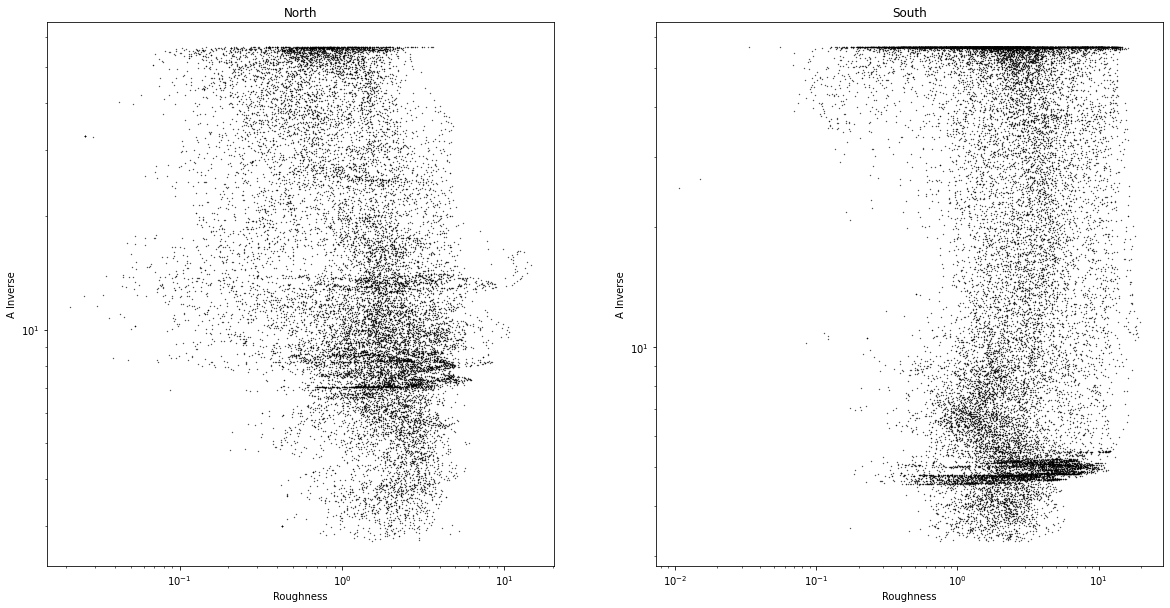

In [97]:
#plotting with bounds for shear margins
fig, ax = plt.subplots(1,2,figsize=(20,10))

north_outline_path = '/home/acdealy/notebooks/ice-shelf-roughness/shapefiles/pig_north_shear (5).shp'
north_shape = gpd.read_file(north_outline_path)
north_shape = north_shape.to_crs(3031)

south_outline_path = '/home/acdealy/notebooks/ice-shelf-roughness/shapefiles/pig_south_shear (3).shp'
south_shape = gpd.read_file(south_outline_path)
south_shape = south_shape.to_crs(3031)

for j in tqdm.trange(np.shape(pig_data)[0]):
    x = np.array(pig_data['E'].iloc[j])
    y = np.array(pig_data['N'].iloc[j])
    r = np.array(pig_data['R'].iloc[j])
    a = np.array(pig_data['A_inv'].iloc[j])
    on_north = []
    on_south = []
    for k in range(len(pig_data['E'].iloc[j])):
        pts_on_north = north_shape.contains(Point(x[k],y[k]))
        on_north.append(pts_on_north.values[0])
        pts_on_south = south_shape.contains(Point(x[k],y[k]))
        on_south.append(pts_on_south.values[0])
    on_north = np.array(on_north)
    on_south = np.array(on_south)
    x_north = x[on_north==True]
    y_north = y[on_north==True]
    r_north = r[on_north==True]
    a_north = a[on_north == True]
    x_south = x[on_south==True]
    y_south = y[on_south==True]
    r_south = r[on_south==True]
    a_south = a[on_south == True]
    points_north = ax[0].scatter(r_north, a_north, c='k', s=.1)
    points_south = ax[1].scatter(r_south, a_south, c='k', s=.1)
    
#NEED TO BOUND TO PIG MASK!!!!!!!!!!!!!!!!!!!

ax[0].set_title('North')
ax[1].set_title('South')
ax[0].set_xlabel('Roughness')
ax[0].set_ylabel('A Inverse')
ax[1].set_xlabel('Roughness')
ax[1].set_ylabel('A Inverse')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
plt.show()

100%|██████████| 847/847 [00:50<00:00, 16.67it/s]


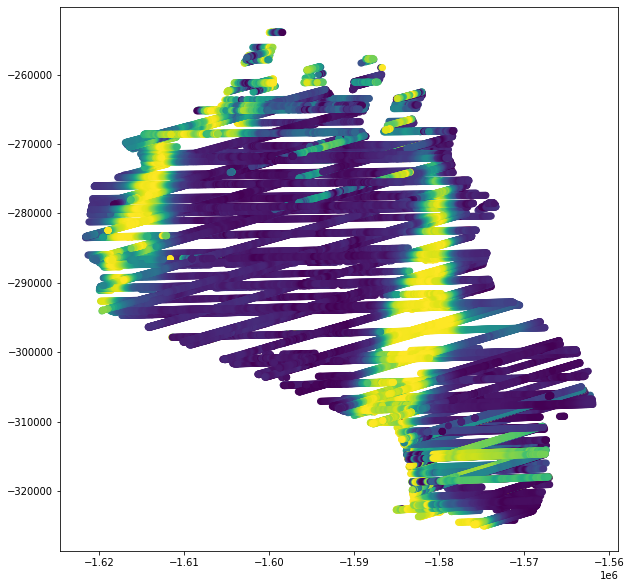

In [98]:
fig, ax = plt.subplots(figsize=(10,10))

study_shelf_id = 590802
all_shelf_outline_path = '/home/acdealy/notebooks/ice-shelf-roughness/shapefiles/USNIC_ANTARC_shelf_2022_epsg3031.shp'
all_shelf_outline = gpd.read_file(all_shelf_outline_path)
shape = all_shelf_outline[all_shelf_outline['OBJECTID']==study_shelf_id] 

roughness = []
inverse = []
easting = []
northing = []
difference = []

#plotting difference of a and r spatially
for j in tqdm.trange(np.shape(pig_data)[0]):
    x = np.array(pig_data['E'].iloc[j])
    y = np.array(pig_data['N'].iloc[j])
    r = np.array(pig_data['R'].iloc[j])
    a = np.array(pig_data['A_inv'].iloc[j])
    on_shelf = []
    for k in range(len(pig_data['E'].iloc[j])):
        pts_on_shelf = shape.contains(Point(x[k],y[k]))
        on_shelf.append(pts_on_shelf.values[0])
    on_shelf = np.array(on_shelf)
    x = x[on_shelf==True]
    y = y[on_shelf==True]
    r = r[on_shelf==True]
    a = a[on_shelf == True]
    a_norm = a/np.max(a.values)
    r_norm 
    diff = a-r
    roughness.append(r)
    inverse.append(a)
    easting.append(x)
    northing.append(y)
    difference.append(diff)
    points = ax.scatter(x,y,c=diff)